In [1]:
import argparse
import importlib.util

import tensorflow as tf
import h5py
from sklearn.metrics import roc_curve
import pickle
import matplotlib.pyplot as plt

from alad_mod.alad import ALAD
from data.hlf_dataset_utils import *
from data.hlf_preprocessing import load
from core.histogram_builder import *


In [2]:
result_path = 'model'
model_file = 'model-10000000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config_alad, tf.Session())
ad.load(os.path.join(result_path, model_file))


loading alad
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in 

/home/oliverkn/pro/pycharm/pycharm/venv37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/oliverkn/pro/pycharm/pycharm/venv37/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/oliverkn/pro/pycharm/pycharm/venv37/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at y

In [3]:
file_mc = '/home/oliverkn/pro/opendata_v2/b_mix_pre.hdf5'
file_ttbar = '/home/oliverkn/pro/opendata_v2/9588/data_pre.hdf5'

x_mc = h5py.File(file_mc, "r")['data']
x_ttbar = h5py.File(file_ttbar, "r")['data']


/home/oliverkn/pro/pycharm/pycharm/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/home/oliverkn/pro/pycharm/pycharm/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/oliverkn/pro/pycharm/pycharm/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/home/oliverkn/pro/pycharm/pycharm/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/oliverkn/pro/pycharm/pycharm/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/home/oliverkn/pro/pycharm/pycharm/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/oliverkn/pro/pycharm/pycharm/venv37/lib/python3.7/site-packages/ipykernel

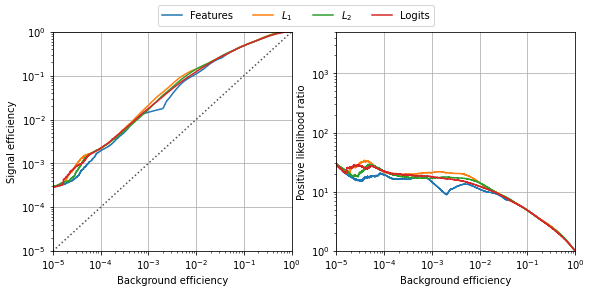

In [4]:
n_max = int(100e5)
fpr_lim = 1e-5
# 
x_mc_transformed = preprocessor.transform(x_mc[:n_max])
x_ttbar_transformed = preprocessor.transform(x_ttbar[:n_max])

mc_scores = ad.compute_all_scores(x_mc_transformed)
ttbar_scores = ad.compute_all_scores(x_ttbar_transformed)

y = np.concatenate([np.zeros_like(mc_scores[0]), np.ones_like(ttbar_scores[0])])
score_names = ['Features', r'$L_1$', r'$L_2$', 'Logits']

fig, ax_arr = plt.subplots(1, 2, figsize=(8, 4))

ax_arr[0].set(xlim=(fpr_lim, 1), ylim=(fpr_lim, 1))
ax_arr[0].set_xlabel('Background efficiency')
ax_arr[0].set_ylabel('Signal efficiency')
ax_arr[0].set_xscale('log')
ax_arr[0].set_yscale('log')
ax_arr[0].grid()

ax_arr[1].set(xlim=(fpr_lim, 1), ylim=(1, 5e3))
ax_arr[1].set_xlabel('Background efficiency')
ax_arr[1].set_ylabel('Positive likelihood ratio')
ax_arr[1].set_xscale('log')
ax_arr[1].set_yscale('log')
ax_arr[1].grid()

for j, name in enumerate(score_names):
    score = np.concatenate([mc_scores[j], ttbar_scores[j]])
    fpr, tpr, _ = roc_curve(y, score, pos_label=1)
    ax_arr[0].loglog(fpr, tpr, label=name)

    #plot LR+
    lrp = tpr/fpr
    ax_arr[1].step(fpr, lrp, label=name)

#plot diagonal line
ax_arr[0].plot(ax_arr[0].get_xlim(), ax_arr[0].get_ylim(), ls=":", c=".3")

handles, labels = ax_arr[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', ncol=4)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0, rect=(0,0,1,0.93))

plt.savefig('output/roc-tt.pdf')
plt.show()